In [1]:
import papermill as pm
import pandas as pd
import geopandas as gpd
import asyncio
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt
import matplotlib.patheffects as pe
import json
import contextily as cx
import winsound

Traject analyse:
Drachten -> Lemmer: 93 -> 185 (via verbinding snelweg)
Leeuwarden -> Heerenveen: 1000 -> 1006

Wat te doen?
1. Normaal simuleren
2. 3 baans snelweg
3. 130 km/h snelweg
4. cruciale weg verwijderen
5. Bevolking x1.5 oid
6. Bevolking x1.5 + 3baans + 130 km/h

SLUITEN:
168-167 (LW-HV)
245-250 (DR-LE)

In [2]:
nbanen = 3
maxshd = 130
highway_def = {
            (175, 197): {'nbanen': nbanen}, 
            (169, 197): {'nbanen': nbanen}, 
            (168, 169): {'nbanen': nbanen}, 
            (189, 168): {'nbanen': nbanen}, 
            (149, 189): {'nbanen': nbanen}
        }
highway_def2 = {
            (175, 197): {'maxshd': maxshd}, 
            (169, 197): {'maxshd': maxshd}, 
            (168, 169): {'maxshd': maxshd}, 
            (189, 168): {'maxshd': maxshd}, 
            (149, 189): {'maxshd': maxshd}
        }

highway_def3 = {
    (95, 93): {'nbanen': nbanen}, 
    (246, 95): {'nbanen': nbanen}, 
    (91, 246): {'nbanen': nbanen}, 
    (149, 91): {'nbanen': nbanen}, 
    (150, 149): {'nbanen': nbanen}, 
    (151, 150): {'nbanen': nbanen}, 
    (215, 151): {'nbanen': nbanen}, 
    (213, 215): {'nbanen': nbanen}, 
    (210, 213): {'nbanen': nbanen}, 
    (211, 210): {'nbanen': nbanen}, 
    (190, 211): {'nbanen': nbanen}, 
    (190, 185): {'nbanen': nbanen}, 
}

highway_def4 = {
    (95, 93): {'maxshd': maxshd}, 
    (246, 95): {'maxshd': maxshd}, 
    (91, 246): {'maxshd': maxshd}, 
    (149, 91): {'maxshd': maxshd}, 
    (150, 149): {'maxshd': maxshd}, 
    (151, 150): {'maxshd': maxshd}, 
    (215, 151): {'maxshd': maxshd}, 
    (213, 215): {'maxshd': maxshd}, 
    (210, 213): {'maxshd': maxshd}, 
    (211, 210): {'maxshd': maxshd}, 
    (190, 211): {'maxshd': maxshd}, 
    (190, 185): {'maxshd': maxshd}, 
}

highway_def5 = {
    (175, 197): {'nbanen': nbanen}, 
    (169, 197): {'nbanen': nbanen}, 
    (168, 169): {'nbanen': nbanen}, 
    (189, 168): {'nbanen': nbanen}, 
    (149, 189): {'nbanen': nbanen},

    (95, 93): {'nbanen': nbanen}, 
    (246, 95): {'nbanen': nbanen}, 
    (91, 246): {'nbanen': nbanen}, 
    (149, 91): {'nbanen': nbanen}, 
    (150, 149): {'nbanen': nbanen}, 
    (151, 150): {'nbanen': nbanen}, 
    (215, 151): {'nbanen': nbanen}, 
    (213, 215): {'nbanen': nbanen}, 
    (210, 213): {'nbanen': nbanen}, 
    (211, 210): {'nbanen': nbanen}, 
    (190, 211): {'nbanen': nbanen}, 
    (190, 185): {'nbanen': nbanen}, 
}

highway = {k1*1e6+k2: v for (k1, k2), v in highway_def.items()}
highway2 = {k1*1e6+k2: v for (k1, k2), v in highway_def2.items()}
highway3 = {k1*1e6+k2: v for (k1, k2), v in highway_def3.items()}
highway4 = {k1*1e6+k2: v for (k1, k2), v in highway_def4.items()}
highway5 = {k1*1e6+k2: v for (k1, k2), v in highway_def5.items()}
# highway = {}

In [3]:
amount = 6 # 12, 6
init = 75 # 50, 75
minutes = 450 # 100, 450
def blocking_notebook(number, highway_data):
    print(f'Running notebook {number}')
    pm.execute_notebook(
        './extended graph model (3).ipynb', 
        f'./gendata/run {number}.ipynb',
        progress_bar=False,
        parameters={
            'minutes_initialization': init,
            'minutes_simulation': minutes,
            'save_to': f'test{number}.csv',
            'traveltime_saveto': f'traveltime{number}.json',
            'road_modifications': highway_data,
        })
    print(f'Simulation {number} complete!')


async def main(highway_data, offset=0):
    tasks = [asyncio.to_thread(blocking_notebook, i + 1 + offset, highway_data) for i in range(0, amount)]
    await asyncio.gather(*tasks)

# pm.execute_notebook(
#     './extended graph model (3).ipynb', 
#     './gendata/test1.ipynb',
#     parameters={'minutes_simulation': 60, 'save_to': 'test1.csv'})

In [ ]:
# await asyncio.gather(
#     main(highway, offset=0), # hv 3lanes
#     main(highway2, offset=6), # hv 130kmh
#     main(highway3, offset=12), # drle 3lanes
#     main(highway4, offset=18), # drle 130kmh
# )

await main(highway5) # enable delete_roads !!!!

print('Done!')

# make sound when done
# for j in range(1):
#     for i in range(3, 10):
#         winsound.Beep(i * 100, 500)

Running notebook 1Running notebook 2
Running notebook 3
Running notebook 4

Running notebook 5
Running notebook 6


## Capacity plot

In [4]:
def load_files(folder, amount_files, offset=0):
    files = list()
    for j in range(0, amount_files):
        ldf = pd.read_csv(f'./gendata/{folder}test{j+1+offset}.csv')
        ldf = ldf[~ldf['geometry'].isnull()] # remove bad geometry (is NaN)
        ldf['geometry'] = ldf['geometry'].apply(wkt.loads)
        ldf = gpd.GeoDataFrame(ldf, crs='epsg:3857')
        ldf = ldf.explode()
        files.append(ldf)
    return files

C:\Users\Alexander\AppData\Local\Temp\ipykernel_8168\1262841.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('autumn_r', 100)
C:\Users\Alexander\AppData\Local\Temp\ipykernel_8168\1262841.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = plt.cm.get_cmap('cool', 100)
C:\Users\Alexander\AppData\Local\Temp\ipykernel_8168\1262841.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])


(Leeuwarden simple, outer ring): 64%
(Leeuwarden simple, outer ring): 76%
(Leeuwarden simple, outer ring): 66%


C:\Users\Alexander\AppData\Local\Temp\ipykernel_8168\1262841.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])


(Leeuwarden new, outer ring): 54%
(Leeuwarden new, outer ring): 57%
(Leeuwarden new, outer ring): 55%
(Leeuwarden new, outer ring): 59%


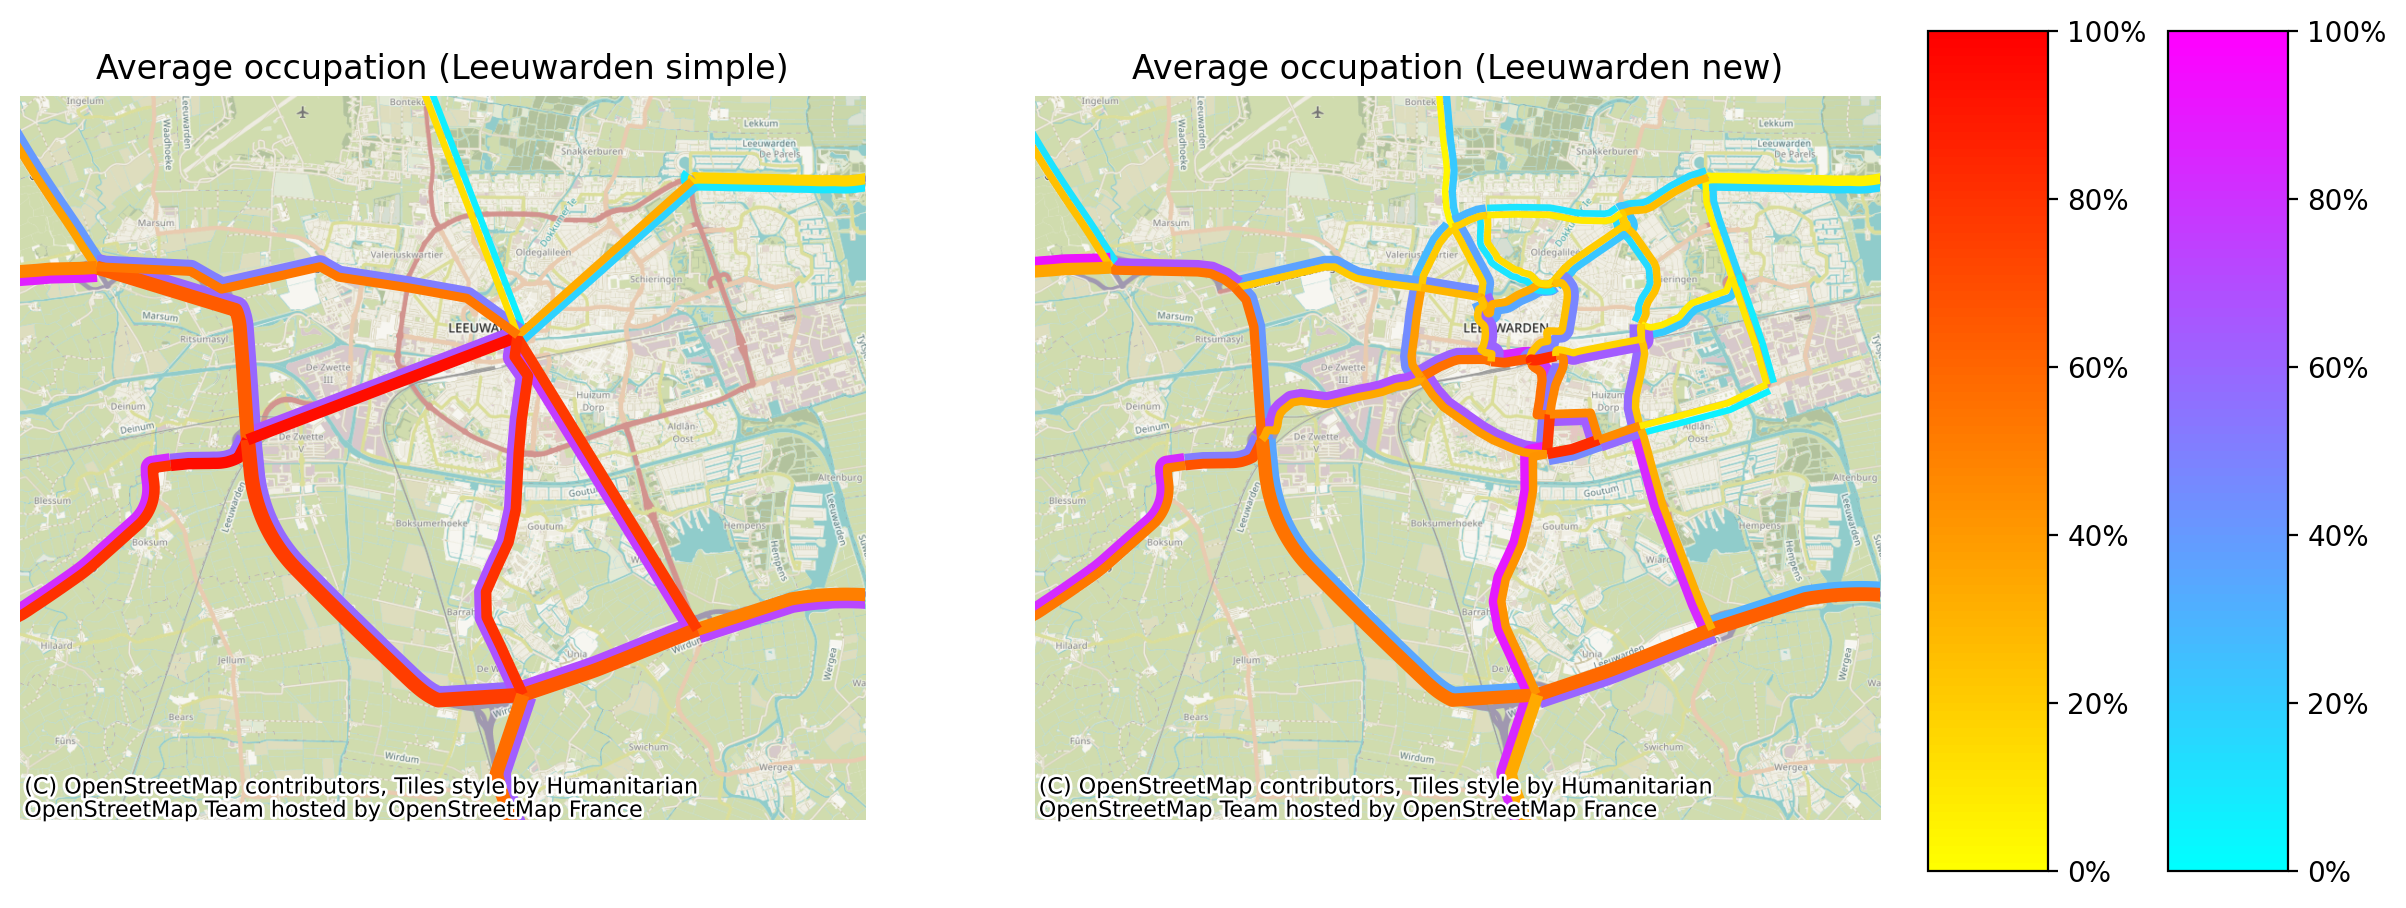

In [5]:
folders = [load_files('lw simple/', 5), load_files('lw new/', 5)]
labels = ['Leeuwarden simple', 'Leeuwarden new']
# lwk = load_files('', 1)

fig, (ax) = plt.subplots(1, len(folders), figsize=(len(folders)*6, 7), dpi=200)
# plt.figure(figsize=(8,8), dpi=200)
# ax = plt.subplot()

if len(folders) == 1:
    ax = [ax]

cmap = plt.cm.get_cmap('autumn_r', 100)
cmap2 = plt.cm.get_cmap('cool', 100)

cax = plt.axes([0.92, 0.2, 0.05, 0.6])
cax2 = plt.axes([0.92+0.1, 0.2, 0.05, 0.6])

# left_shift2 = lines_gpd.apply(lambda r: r.geometry.offset_curve(-400), axis=1)

def show_plot(ax, ldf, label):
    # offset line
    left_shift2 = ldf.copy()
    line_offset2 = 150
    def update_offset2(row):
        return row.geometry.offset_curve(-line_offset2)
    left_shift2['geometry'] = left_shift2.apply(update_offset2, axis=1)

    # configure coordinates of plane, comment out to ignore
    ax.set_xlim(63.5e4, 65.25e4)
    ax.set_ylim(7.01e6, 7.025e6)
    ax.set_title(f"Average occupation ({label})")

    left_shift2.plot(ax=ax, column=ldf[f"avgb"]/ldf["capacity"],
                    cmap='cool',
                    linewidth=0.7+ldf['nbanen']*1.5 + 2*ldf[f"avgb"]/ldf["capacity"],
                    zorder=1)
    ldf.plot(ax=ax, column=ldf[f"avgf"]/ldf["capacity"],
                    cmap='autumn_r',
                    linewidth=0.7+ldf['nbanen']*1.5 + 2*ldf[f"avgf"]/ldf["capacity"],
                    zorder=1)
    
    cx.add_basemap(ax)

    ax.set_axis_off()

    
    bar_info = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
    bar_info._A = [] ### geen idee wat dit doet
    cbar = plt.colorbar(bar_info, cax=cax, ax=ax, ticks=[0, 20, 40, 60, 80, 100])
    cbar.ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    bar_info = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=0, vmax=100))
    bar_info._A = [] ### geen idee wat dit doet
    cbar = plt.colorbar(bar_info, cax=cax2, ax=ax)
    cbar.ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

    def calc_intensity(edge):
        row = ldf[(ldf['node_start'] == edge[0]) & (ldf['node_end'] == edge[1])]
        return (row['avgf']/row['capacity']).to_list()[0]

    if label == 'Leeuwarden simple':
        for e in [(174, 108), (175, 174), (6, 175)]:
            print(f'({label}, outer ring): {calc_intensity(e)*100:.0f}%')
    if label == 'Leeuwarden new':
        for e in [(703, 108), (174, 703), (175, 174), (175, 6)]:
            print(f'({label}, outer ring): {calc_intensity(e)*100:.0f}%')

for i in range(len(folders)):
    ldf = folders[i][0]
    for j in range(len(folders[i])):
        # take average across all minutes excl initialization
        ldf[f'avgf{j}'] = folders[i][j][[f'f{k}' for k in range(0, 60)]].mean(axis=1)
        ldf[f'avgb{j}'] = folders[i][j][[f'b{k}' for k in range(0, 60)]].mean(axis=1)
    
    ldf['avgf'] = ldf[[f'avgf{j}' for j in range(len(folders[i]))]].mean(axis=1)
    ldf['avgb'] = ldf[[f'avgb{j}' for j in range(len(folders[i]))]].mean(axis=1)
    
    label = labels[i]
    show_plot(ax[i], ldf, label)

## Occupation analysis

In [6]:
def intensity_road(folder, amount_files, minutes, edge):
    forward = np.zeros((amount_files, minutes))
    backward = np.zeros((amount_files, minutes))
    for j in range(0, amount_files):
        ldf = pd.read_csv(f'./gendata/{folder}test{j+1}.csv')
        r = ldf[(ldf['node_start'] == edge[0]) & (ldf['node_end'] == edge[1])]
        forward[j,:] = [r[f'f{i}'].to_list()[0] for i in range(0, 100)]
        backward[j,:] = [r[f'b{i}'].to_list()[0] for i in range(0, 100)]
    return forward, backward

def intensity_road_percentage(folder, amount_files, minutes, edge):
    forward = np.zeros((amount_files, minutes))
    backward = np.zeros((amount_files, minutes))
    for j in range(0, amount_files):
        ldf = pd.read_csv(f'./gendata/{folder}test{j+1}.csv')
        r = ldf[(ldf['node_start'] == edge[0]) & (ldf['node_end'] == edge[1])]
        forward[j,:] = [r[f'f{i}'].to_list()[0]/r['capacity'].to_list()[0]*100 for i in range(0, 100)]
        backward[j,:] = [r[f'b{i}'].to_list()[0]/r['capacity'].to_list()[0]*100 for i in range(0, 100)]
    return forward, backward

In [7]:
# fig, ax = plt.subplots(len(highway.keys()), figsize=(4, 20))
# fig, ax = plt.subplot((20, 10))

plt.figure(figsize=(8, 4))

i = 0
# ax = list()
# for k in highway_def.keys():
#     fw, bw = intensity_road('traveltimes regular/', 12, 100, k)
#     plt.plot(np.mean(fw, axis=0), label=f'forward {k}')
#     plt.plot(np.mean(bw, axis=0), label=f'backward {k}')
    # plt.legend()    
    # plt.set_title(f"Occupation of edge {k}")
    # i += 1
    # plt.show()

fw, bw = intensity_road_percentage('traveltimes 3lanes/', 12, 100, (175, 197))
plt.plot(np.mean(fw, axis=0), label=f'[1] forward {(175, 197)}')
# plt.plot(np.mean(bw, axis=0), label=f'backward {k}'

fw, bw = intensity_road_percentage('traveltimes 3lanes/', 12, 100, (169, 197))
# plt.plot(np.mean(fw, axis=0), label=f'forward {k}')
plt.plot(np.mean(bw, axis=0), label=f'[2] backward {(169, 197)}')

fw, bw = intensity_road_percentage('traveltimes 3lanes/', 12, 100, (168, 169))
# plt.plot(np.mean(fw, axis=0), label=f'forward {k}')
plt.plot(np.mean(bw, axis=0), label=f'[3] backward {(168, 169)}')

fw, bw = intensity_road_percentage('traveltimes 3lanes/', 12, 100, (189, 168))
# plt.plot(np.mean(fw, axis=0), label=f'forward {k}')
plt.plot(np.mean(bw, axis=0), label=f'[4] backward {(189, 168)}')

fw, bw = intensity_road_percentage('traveltimes 3lanes/', 12, 100, (149, 189))
# plt.plot(np.mean(fw, axis=0), label=f'forward {k}')
plt.plot(np.mean(bw, axis=0), label=f'[5] backward {(149, 189)}')

plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './gendata/traveltimes 3lanes/test1.csv'

<Figure size 800x400 with 0 Axes>

## Travel time analysis

In [12]:
def loadtraveltimes(file):
    with open(file) as f:
        tt = json.load(f)
        return {int(n): np.array(json.loads(json_v)) for n, json_v in tt.items()}

Average cars per minute: 0.5214368482039398 veh/min
(regular/) Average travel time: 56.544487477407685 min
Average cars per minute: 0.531810124089029 veh/min
(lw-hv 3baans/) Average travel time: 54.958377773388634 min
Average cars per minute: 0.5310778914240756 veh/min
(lw-hv 130kmh/) Average travel time: 55.23646285338592 min


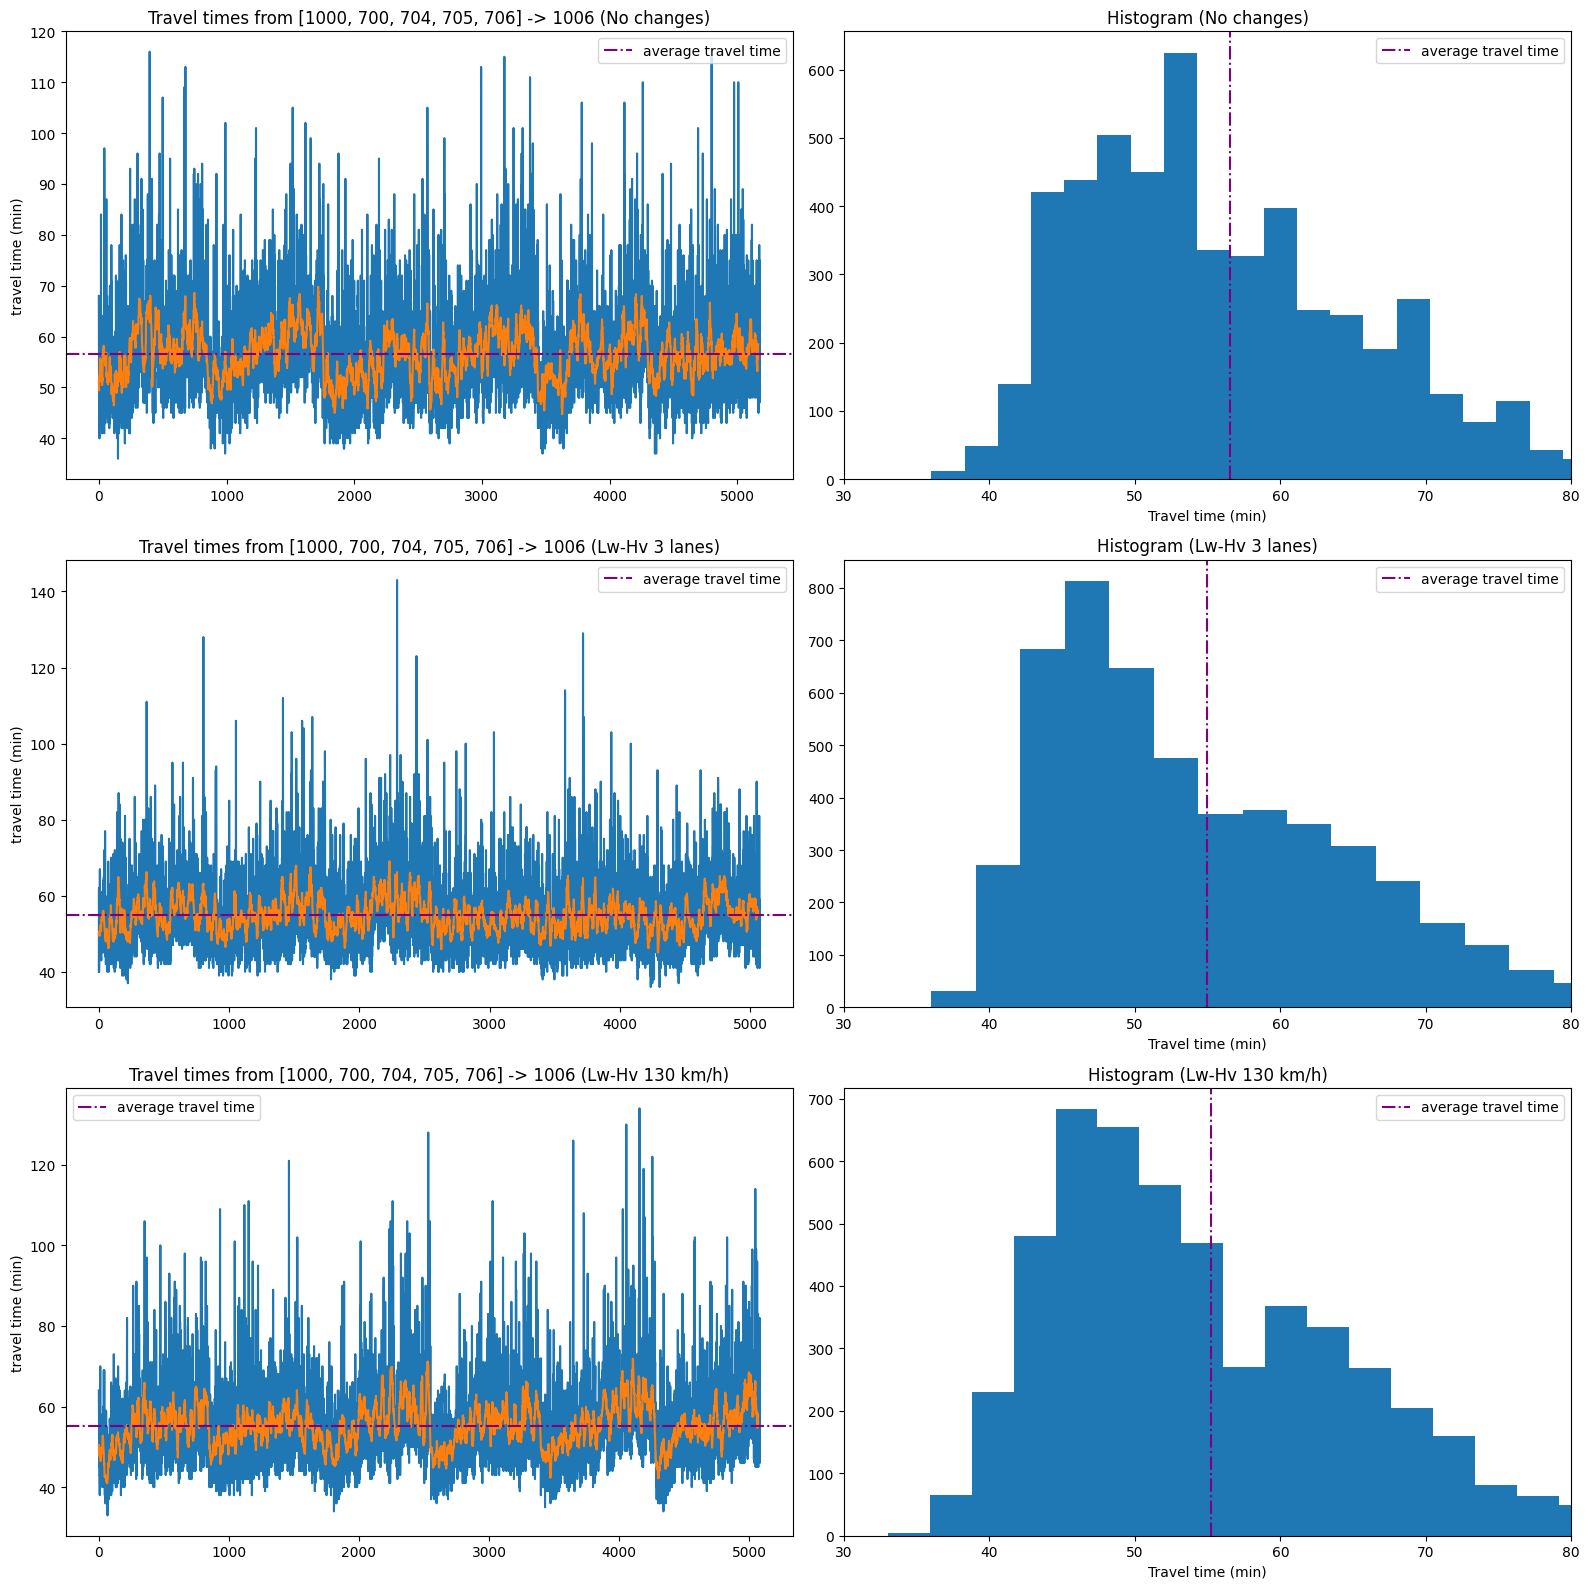

In [13]:
def plot_traveltimes(ax, axhist, folder, amount, label, from_node, to_node, xlim, bins=70, offset=0, offset_data=0):
    traveltimes = np.array([])
    for i in range(amount):
        # new_data = np.fromfile(f'./gendata/{folder}traveltime{i+1}.bin')
        tt = loadtraveltimes(f'./gendata/{folder}traveltime{i+1+offset}.json')
        new_data = tt[to_node]
        new_data = new_data[np.isin(new_data[:, 1], from_node)][:, 0]
        # print(new_data)

        # print(new_data)
        traveltimes = np.concat([traveltimes, new_data[offset_data:]])

    length = len(traveltimes) + offset_data*amount
    total_simulation_time = 6*450
    print(f"Average cars per minute: {total_simulation_time/length} veh/min")


    t2 = traveltimes

    # exavg = 37
    # node_from = 1000 # 1000
    # node_to = 1006 # 1006

    N = 15
    # print(np.ones(N)/N)
    tavg = np.convolve(t2, np.ones(N)/N, mode='valid')
    tavgavg = np.mean(tavg)

    print(f"({folder}) Average travel time: {tavgavg} min")
    # print(f"Travel time: {exavg:.0f} +{(tavgavg-exavg):.0f} min")
    # print(tavg)
    ax.set_title(f"Travel times from {from_node} -> {to_node} ({label})")
    ax.plot(t2)
    ax.plot(tavg)
    ax.axhline(y=tavgavg, ls='-.', color='purple', label='average travel time')
    # ax.axhline(y=exavg, ls='--', color='red', label='expected time without traffic')
    ax.set_ylabel("travel time (min)")
    ax.legend()

    axhist.set_title(f"Histogram ({label})")
    axhist.set_xlabel('Travel time (min)')
    # axhist.set_ylabel('Normalized probability')
    axhist.hist(t2, bins=bins, density=False)
    axhist.set_xlim(xlim)
    axhist.axvline(tavgavg, ls='-.', color='purple', label='average travel time')
    axhist.legend()
    # ax.show()

leeuwarden_set = [1000, 700, 704, 705, 706]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16, 16))

plot_traveltimes(ax1, ax2, 'regular/', 6, 'No changes', leeuwarden_set, 1006, (30, 80), bins=35)
plot_traveltimes(ax3, ax4, 'lw-hv 3baans/', 6, 'Lw-Hv 3 lanes', leeuwarden_set, 1006, (30, 80), bins=35, offset=0)
plot_traveltimes(ax5, ax6, 'lw-hv 130kmh/', 6, 'Lw-Hv 130 km/h', leeuwarden_set, 1006, (30, 80), bins=35, offset=6)

fig.tight_layout()

Average cars per minute: 0.5823986194995686 veh/min
(regular/) Average travel time: 82.68194038573932 min
Average cars per minute: 0.42836744407425037 veh/min
(dr-le 3baans/) Average travel time: 79.47088491517653 min
Average cars per minute: 0.7047768206734534 veh/min
(dr-le 130kmh/) Average travel time: 85.36061648197682 min


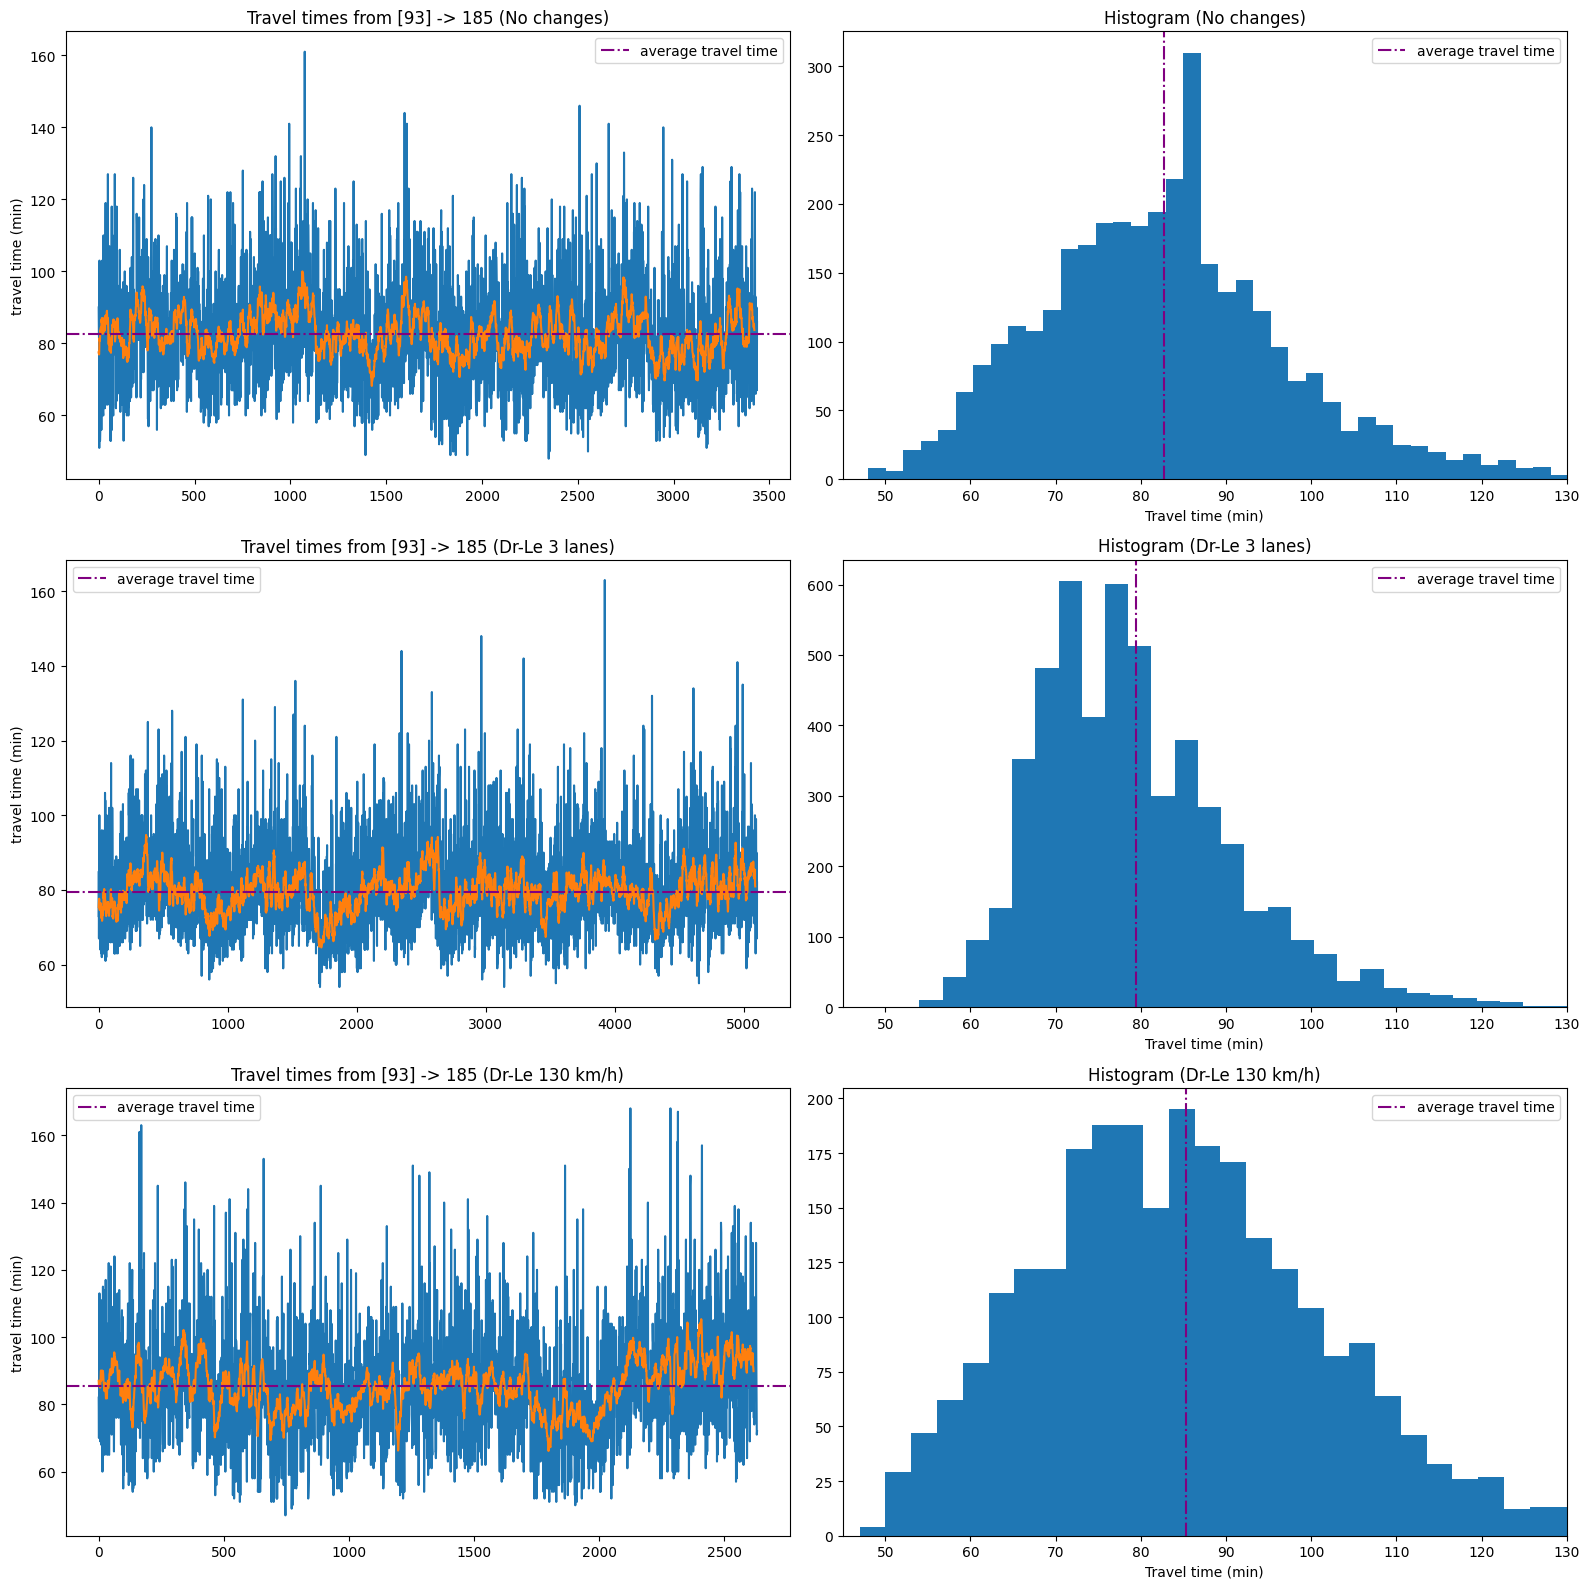

In [14]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16, 16))

plot_traveltimes(ax1, ax2, 'regular/', 6, 'No changes', [93], 185, (45, 130), bins=55, offset_data=200)
plot_traveltimes(ax3, ax4, 'dr-le 3baans/', 6, 'Dr-Le 3 lanes', [93], 185, (45, 130), bins=40, offset=12, offset_data=200)
plot_traveltimes(ax5, ax6, 'dr-le 130kmh/', 6, 'Dr-Le 130 km/h', [93], 185, (45, 130), bins=40, offset=18, offset_data=200)

fig.tight_layout()

Average cars per minute: 0.5214368482039398 veh/min
(regular/) Average travel time: 56.544487477407685 min
Average cars per minute: 0.5036373810856184 veh/min
(popgrow/) Average travel time: 81.47258716286063 min
Average cars per minute: 0.5823986194995686 veh/min
(regular/) Average travel time: 82.68194038573932 min
Average cars per minute: 0.4963235294117647 veh/min
(popgrow/) Average travel time: 89.75816374822527 min


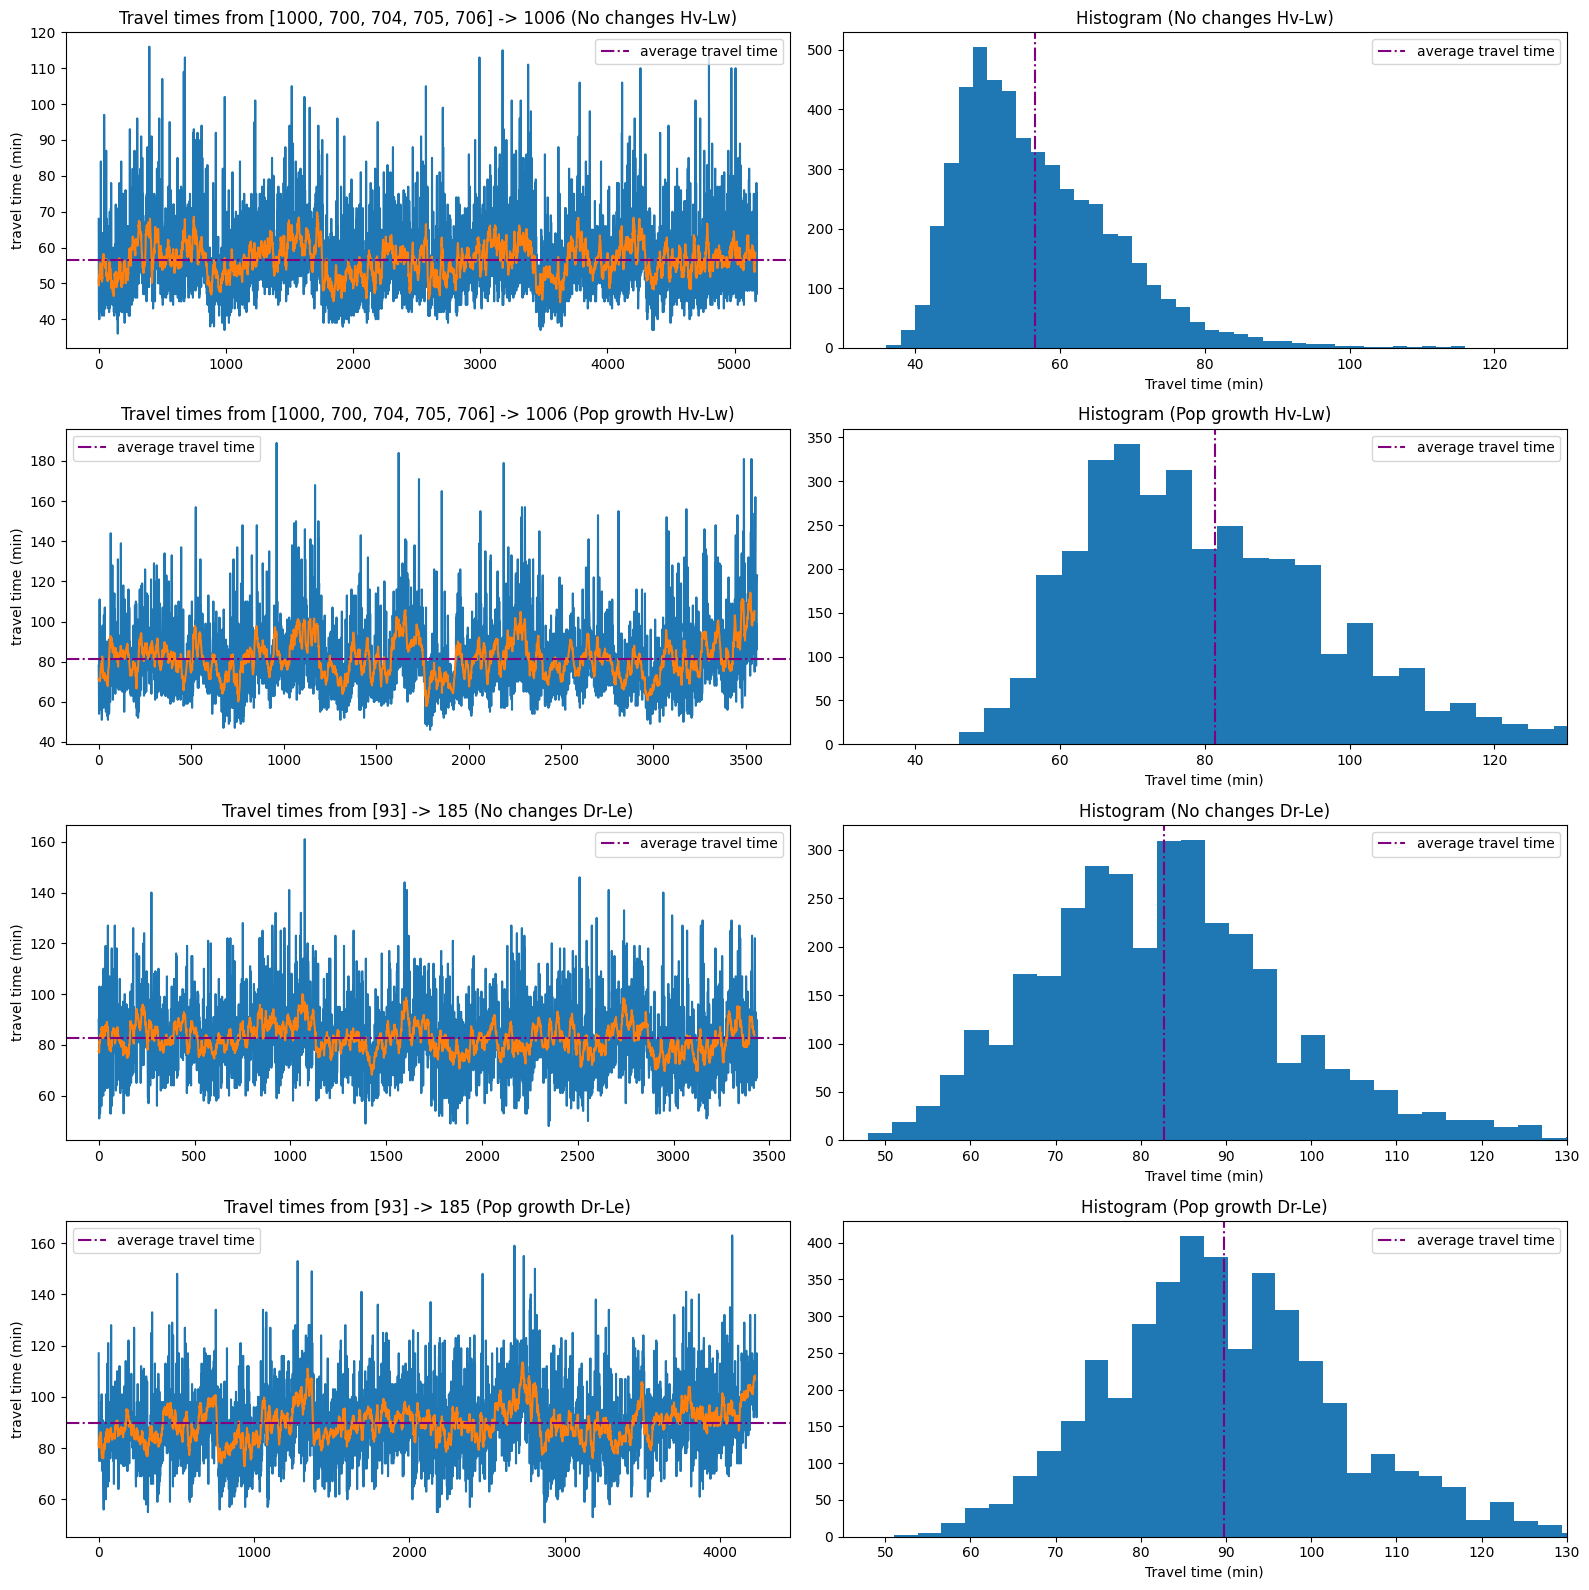

In [15]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(16, 16))

plot_traveltimes(ax1, ax2, 'regular/', 6, 'No changes Hv-Lw', leeuwarden_set, 1006, (30, 130), bins=40)
plot_traveltimes(ax3, ax4, 'popgrow/', 6, 'Pop growth Hv-Lw', leeuwarden_set, 1006, (30, 130), bins=40, offset_data=300)
plot_traveltimes(ax5, ax6, 'regular/', 6, 'No changes Dr-Le', [93], 185, (45, 130), bins=40, offset_data=200)
plot_traveltimes(ax7, ax8, 'popgrow/', 6, 'Pop growth Dr-Le', [93], 185, (45, 130), bins=40, offset_data=200)

fig.tight_layout()

Average cars per minute: 0.5214368482039398 veh/min
(regular/) Average travel time: 56.544487477407685 min
Average cars per minute: 0.5964214711729622 veh/min
(removed/) Average travel time: 113.46295613711759 min
Average cars per minute: 0.8595988538681948 veh/min
(removed/) Average travel time: 118.3838436256703 min
Average cars per minute: 0.5823986194995686 veh/min
(regular/) Average travel time: 82.68194038573932 min


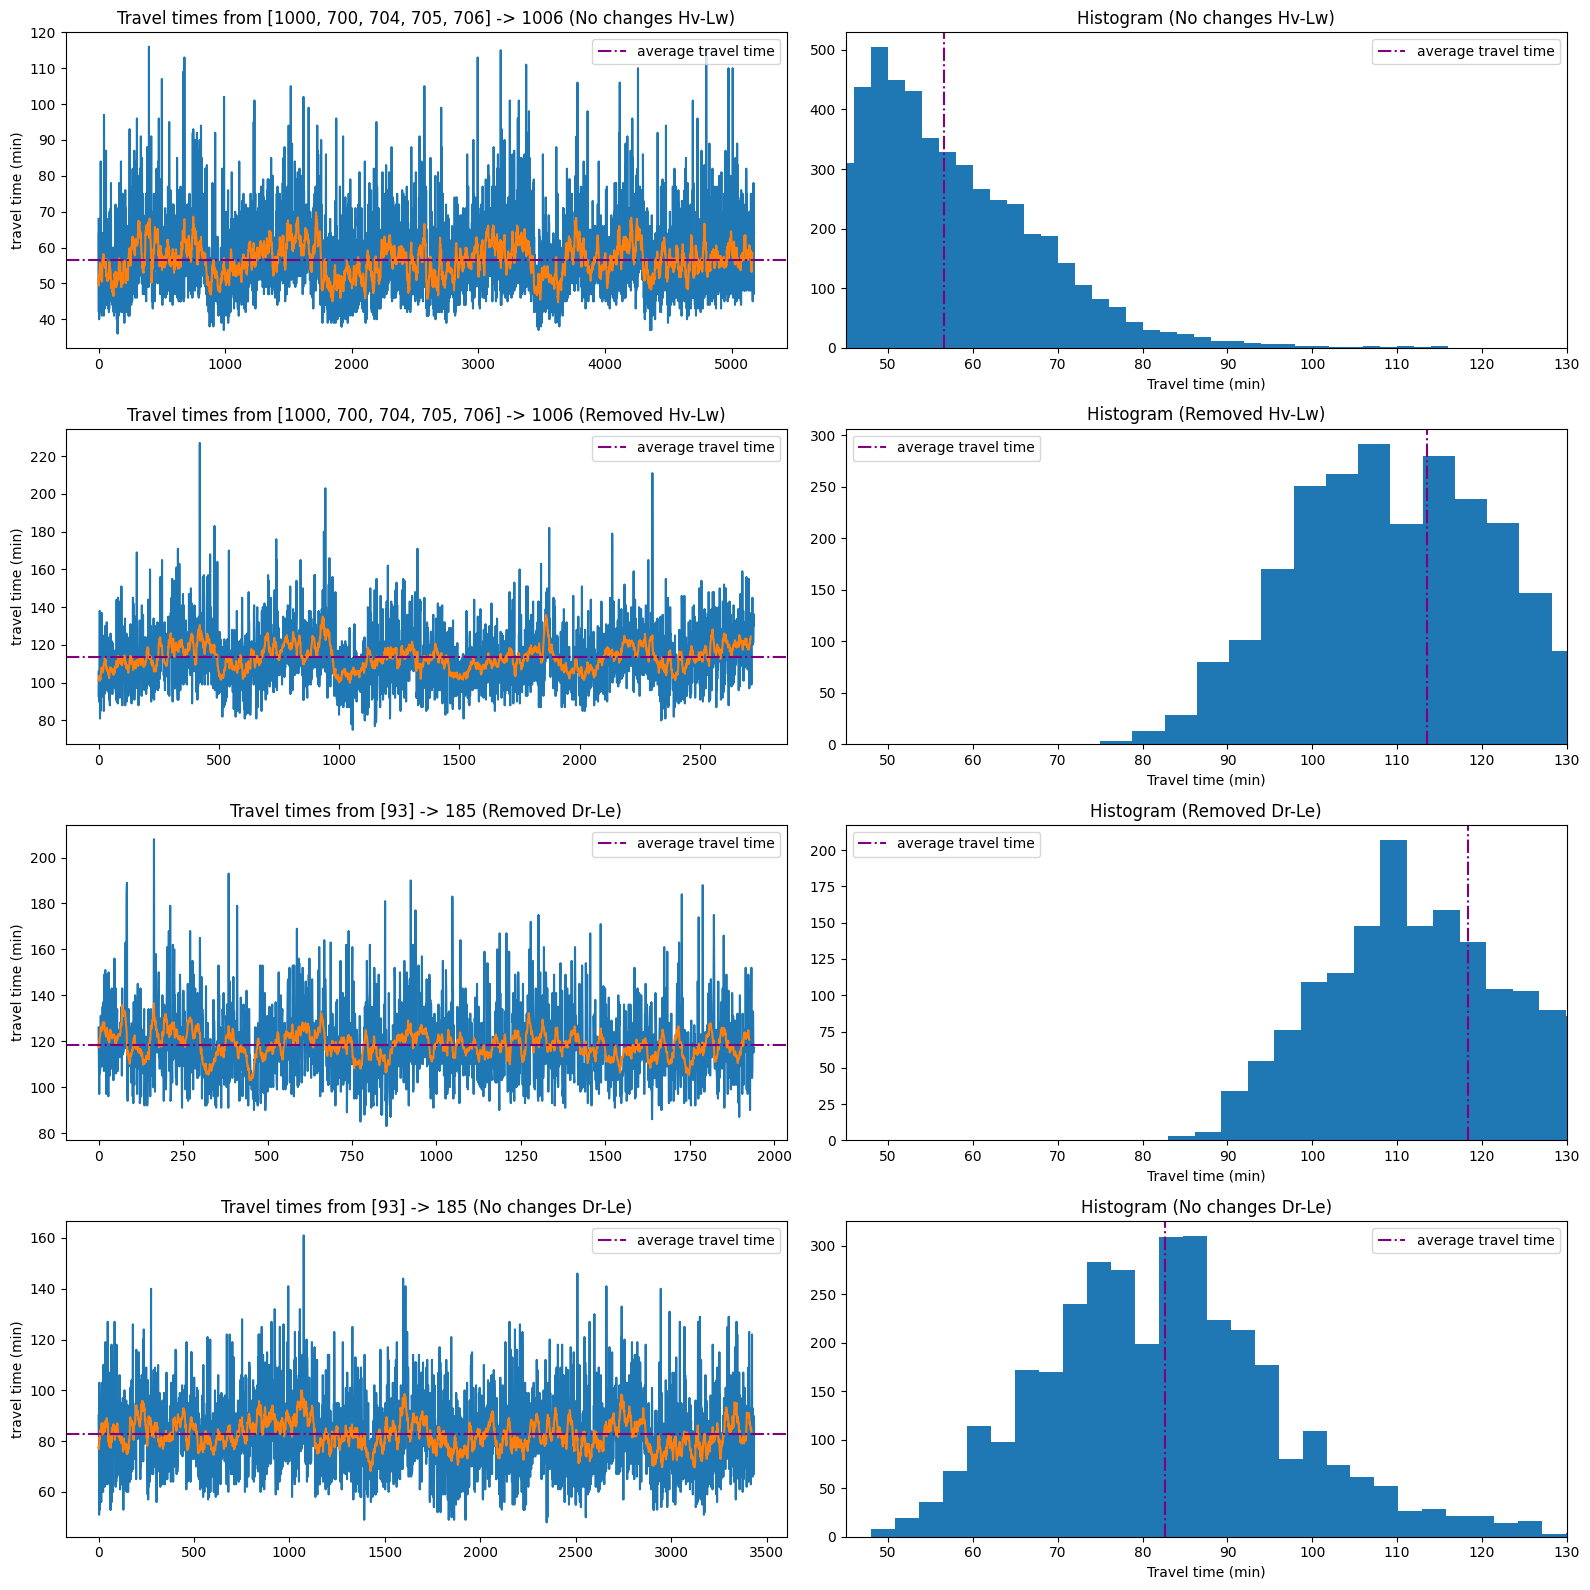

In [16]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(16, 16))

plot_traveltimes(ax1, ax2, 'regular/', 6, 'No changes Hv-Lw', leeuwarden_set, 1006, (45, 130), bins=40)
plot_traveltimes(ax3, ax4, 'removed/', 6, 'Removed Hv-Lw', leeuwarden_set, 1006, (45, 130), bins=40, offset_data=300)
plot_traveltimes(ax5, ax6, 'removed/', 6, 'Removed Dr-Le', [93], 185, (45, 130), bins=40, offset_data=200)
plot_traveltimes(ax7, ax8, 'regular/', 6, 'No changes Dr-Le', [93], 185, (45, 130), bins=40, offset_data=200)

fig.tight_layout()

C:\Users\Alexander\AppData\Local\Temp\ipykernel_8168\1486916773.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('autumn_r', 100)
C:\Users\Alexander\AppData\Local\Temp\ipykernel_8168\1486916773.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = plt.cm.get_cmap('cool', 100)
C:\Users\Alexander\AppData\Local\Temp\ipykernel_8168\1486916773.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
C:\Users\Alexander\AppData\Local\Temp\ipykernel_8168\1486916773.

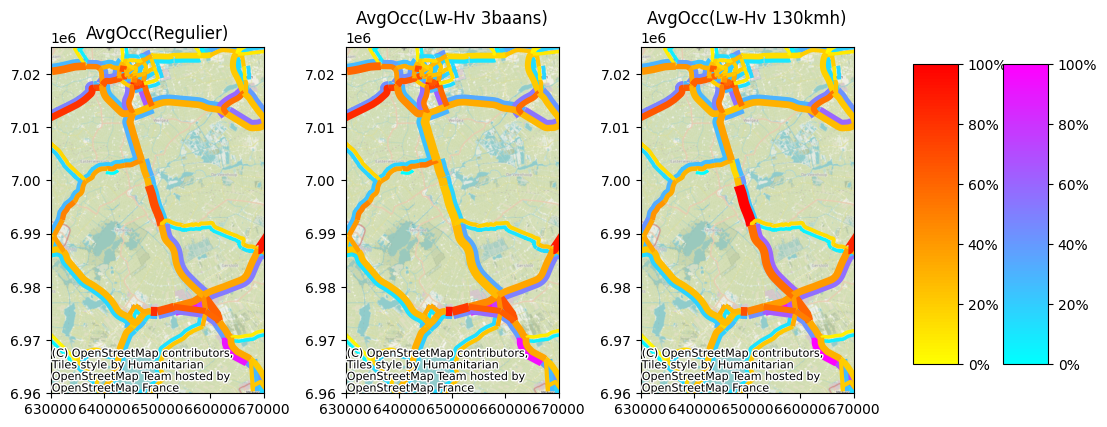

In [17]:
folders = [load_files('regular/', 6), load_files('lw-hv 3baans/', 6, offset=0), load_files('lw-hv 130kmh/', 6, offset=6)]
labels = ['Regulier', 'Lw-Hv 3baans', 'Lw-Hv 130kmh']
# lwk = load_files('', 1)

fig, (ax) = plt.subplots(1, len(folders), figsize=(9, 5))
# plt.figure(figsize=(8,8), dpi=200)
# ax = plt.subplot()

if len(folders) == 1:
    ax = [ax]

cmap = plt.cm.get_cmap('autumn_r', 100)
cmap2 = plt.cm.get_cmap('cool', 100)

cax = plt.axes([0.92 + 0.1, 0.2, 0.05, 0.6])
cax2 = plt.axes([0.92+0.1 + 0.1, 0.2, 0.05, 0.6])

# left_shift2 = lines_gpd.apply(lambda r: r.geometry.offset_curve(-400), axis=1)

def show_plot(ax, ldf, label):
    # offset line
    left_shift2 = ldf.copy()
    line_offset2 = 800
    def update_offset2(row):
        return row.geometry.offset_curve(-line_offset2)
    left_shift2['geometry'] = left_shift2.apply(update_offset2, axis=1)

    # configure coordinates of plane, comment out to ignore
    ax.set_xlim(63e4, 67e4)
    ax.set_ylim(6.96e6, 7.025e6)
    ax.set_title(f"AvgOcc({label})")

    left_shift2.plot(ax=ax, column=ldf[f"avgb"]/ldf["capacity"],
                    cmap='cool',
                    linewidth=0.7+ldf['nbanen']*1.5 + 2*ldf[f"avgb"]/ldf["capacity"],
                    zorder=1)
    ldf.plot(ax=ax, column=ldf[f"avgf"]/ldf["capacity"],
                    cmap='autumn_r',
                    linewidth=0.7+ldf['nbanen']*1.5 + 2*ldf[f"avgf"]/ldf["capacity"],
                    zorder=1)
    
    cx.add_basemap(ax)
    
    bar_info = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
    bar_info._A = [] ### geen idee wat dit doet
    cbar = plt.colorbar(bar_info, cax=cax, ax=ax, ticks=[0, 20, 40, 60, 80, 100])
    cbar.ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    bar_info = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=0, vmax=100))
    bar_info._A = [] ### geen idee wat dit doet
    cbar = plt.colorbar(bar_info, cax=cax2, ax=ax)
    cbar.ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

    def calc_intensity(edge):
        row = ldf[(ldf['node_start'] == edge[0]) & (ldf['node_end'] == edge[1])]
        return (row['avgf']/row['capacity']).to_list()[0]

    if label == 'Leeuwarden simple':
        for e in [(174, 108), (175, 174), (6, 175)]:
            print(f'({label}, outer ring): {calc_intensity(e)*100:.0f}%')
    if label == 'Leeuwarden new':
        for e in [(703, 108), (174, 703), (175, 174), (175, 6)]:
            print(f'({label}, outer ring): {calc_intensity(e)*100:.0f}%')

for i in range(len(folders)):
    ldf = folders[i][0]
    for j in range(len(folders[i])):
        # take average across all minutes excl initialization
        ldf[f'avgf{j}'] = folders[i][j][[f'f{k}' for k in range(0, 450)]].mean(axis=1)
        ldf[f'avgb{j}'] = folders[i][j][[f'b{k}' for k in range(0, 450)]].mean(axis=1)
        ldf[f'avgmaxshdf{j}'] = folders[i][j][[f'maxshdf{k}' for k in range(0, 450)]].mean(axis=1)
        ldf[f'avgmaxshdb{j}'] = folders[i][j][[f'maxshdb{k}' for k in range(0, 450)]].mean(axis=1)
    
    ldf['avgf'] = ldf[[f'avgf{j}' for j in range(len(folders[i]))]].mean(axis=1)
    ldf['avgb'] = ldf[[f'avgb{j}' for j in range(len(folders[i]))]].mean(axis=1)
    ldf['avgmaxshdf'] = ldf[[f'avgmaxshdf{j}' for j in range(len(folders[i]))]].mean(axis=1)
    ldf['avgmaxshdb'] = ldf[[f'avgmaxshdb{j}' for j in range(len(folders[i]))]].mean(axis=1)
    
    label = labels[i]
    show_plot(ax[i], ldf, label)

fig.tight_layout()

In [18]:
folders = [load_files('regular/', 6), load_files('lw-hv 3baans/', 6, offset=0), load_files('lw-hv 130kmh/', 6, offset=6)]
labels = ['Regulier', 'Lw-Hv 3baans', 'Lw-Hv 130kmh']

for i in range(len(folders)):
    ldf = folders[i][0]
    for j in range(len(folders[i])):
        # take average across all minutes excl initialization
        # ldf[f'avgf{j}'] = folders[i][j][[f'f{k}' for k in range(0, 450)]].mean(axis=1)
        # ldf[f'avgb{j}'] = folders[i][j][[f'b{k}' for k in range(0, 450)]].mean(axis=1)
        ldf[f'avgmaxshdf{j}'] = folders[i][j][[f'maxshdf{k}' for k in range(0, 450)]].mean(axis=1)
        ldf[f'avgmaxshdb{j}'] = folders[i][j][[f'maxshdb{k}' for k in range(0, 450)]].mean(axis=1)
    
    # ldf['avgf'] = ldf[[f'avgf{j}' for j in range(len(folders[i]))]].mean(axis=1)
    # ldf['avgb'] = ldf[[f'avgb{j}' for j in range(len(folders[i]))]].mean(axis=1)
    ldf['avgmaxshdf'] = ldf[[f'avgmaxshdf{j}' for j in range(len(folders[i]))]].mean(axis=1)
    ldf['avgmaxshdb'] = ldf[[f'avgmaxshdb{j}' for j in range(len(folders[i]))]].mean(axis=1)
    
    label = labels[i]
    edges1 = list(highway_def.keys())
    for e1, e2 in edges1:
        r = ldf[(ldf['node_start'] == e1) & (ldf['node_end'] == e2)]
        avgshd = r['avgmaxshdf'].to_list()[0]
        maxshd = r['maxshd'].to_list()[0]
        print(f'[{label}] ({e1} -> {e2}) avg shd: {avgshd:.1f} km/h of {maxshd} km/h ({(avgshd-maxshd)/maxshd*100:.2f}% delta)')

[Regulier] (175 -> 197) avg shd: 100.0 km/h of 100 km/h (0.00% delta)
[Regulier] (169 -> 197) avg shd: 100.0 km/h of 100 km/h (0.00% delta)
[Regulier] (168 -> 169) avg shd: 80.0 km/h of 80 km/h (0.00% delta)
[Regulier] (189 -> 168) avg shd: 56.1 km/h of 100 km/h (-43.94% delta)
[Regulier] (149 -> 189) avg shd: 99.9 km/h of 100 km/h (-0.08% delta)
[Lw-Hv 3baans] (175 -> 197) avg shd: 100.0 km/h of 100 km/h (0.00% delta)
[Lw-Hv 3baans] (169 -> 197) avg shd: 100.0 km/h of 100 km/h (0.00% delta)
[Lw-Hv 3baans] (168 -> 169) avg shd: 80.0 km/h of 80 km/h (0.00% delta)
[Lw-Hv 3baans] (189 -> 168) avg shd: 99.5 km/h of 100 km/h (-0.46% delta)
[Lw-Hv 3baans] (149 -> 189) avg shd: 100.0 km/h of 100 km/h (0.00% delta)
[Lw-Hv 130kmh] (175 -> 197) avg shd: 130.0 km/h of 130 km/h (0.00% delta)
[Lw-Hv 130kmh] (169 -> 197) avg shd: 130.0 km/h of 130 km/h (0.00% delta)
[Lw-Hv 130kmh] (168 -> 169) avg shd: 130.0 km/h of 130 km/h (0.00% delta)
[Lw-Hv 130kmh] (189 -> 168) avg shd: 65.0 km/h of 130 km/h (-

C:\Users\Alexander\AppData\Local\Temp\ipykernel_8168\982259471.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('autumn_r', 100)
C:\Users\Alexander\AppData\Local\Temp\ipykernel_8168\982259471.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = plt.cm.get_cmap('cool', 100)
C:\Users\Alexander\AppData\Local\Temp\ipykernel_8168\982259471.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
C:\Users\Alexander\AppData\Local\Temp\ipykernel_8168\982259471.py:5

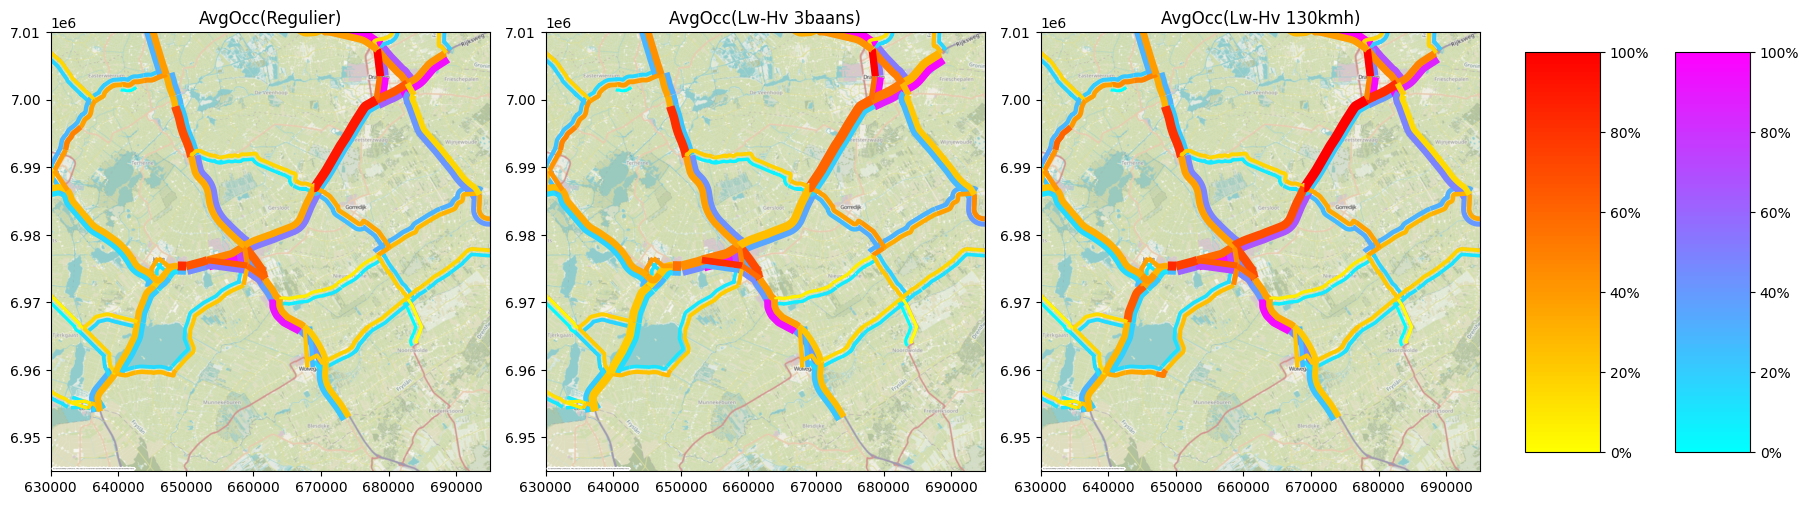

In [19]:
folders = [load_files('regular/', 6), load_files('dr-le 3baans/', 6, offset=12), load_files('dr-le 130kmh/', 6, offset=18)]
labels = ['Regulier', 'Lw-Hv 3baans', 'Lw-Hv 130kmh']
# lwk = load_files('', 1)

fig, (ax) = plt.subplots(1, len(folders), figsize=(15, 5))
# plt.figure(figsize=(8,8), dpi=200)
# ax = plt.subplot()

if len(folders) == 1:
    ax = [ax]

cmap = plt.cm.get_cmap('autumn_r', 100)
cmap2 = plt.cm.get_cmap('cool', 100)

# cax = plt.axes([0.92 +0.1, 0.2, 0.05, 0.6])
# cax2 = plt.axes([0.92+0.1 +0.1, 0.2, 0.05, 0.6])

cax = plt.axes([0.92 +0.1, 0.1, 0.05, 0.8])
cax2 = plt.axes([0.92+0.1 +0.1, 0.1, 0.05, 0.8])


# left_shift2 = lines_gpd.apply(lambda r: r.geometry.offset_curve(-400), axis=1)

def show_plot(ax, ldf, label):
    # offset line
    left_shift2 = ldf.copy()
    line_offset2 = 800
    def update_offset2(row):
        return row.geometry.offset_curve(-line_offset2)
    left_shift2['geometry'] = left_shift2.apply(update_offset2, axis=1)

    # configure coordinates of plane, comment out to ignore
    ax.set_xlim(63e4, 69.5e4)
    ax.set_ylim(6.945e6, 7.01e6)
    ax.set_title(f"AvgOcc({label})")

    left_shift2.plot(ax=ax, column=ldf[f"avgb"]/ldf["capacity"],
                    cmap='cool',
                    linewidth=0.7+ldf['nbanen']*1.5 + 2*ldf[f"avgb"]/ldf["capacity"],
                    zorder=1)
    ldf.plot(ax=ax, column=ldf[f"avgf"]/ldf["capacity"],
                    cmap='autumn_r',
                    linewidth=0.7+ldf['nbanen']*1.5 + 2*ldf[f"avgf"]/ldf["capacity"],
                    zorder=1)
    
    cx.add_basemap(ax, attribution_size=1)

    # ax.set_axis_off()

    
    bar_info = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
    bar_info._A = [] ### geen idee wat dit doet
    cbar = plt.colorbar(bar_info, cax=cax, ax=ax, ticks=[0, 20, 40, 60, 80, 100])
    cbar.ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    bar_info = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=0, vmax=100))
    bar_info._A = [] ### geen idee wat dit doet
    cbar = plt.colorbar(bar_info, cax=cax2, ax=ax)
    cbar.ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

    def calc_intensity(edge):
        row = ldf[(ldf['node_start'] == edge[0]) & (ldf['node_end'] == edge[1])]
        return (row['avgf']/row['capacity']).to_list()[0]

    if label == 'Leeuwarden simple':
        for e in [(174, 108), (175, 174), (6, 175)]:
            print(f'({label}, outer ring): {calc_intensity(e)*100:.0f}%')
    if label == 'Leeuwarden new':
        for e in [(703, 108), (174, 703), (175, 174), (175, 6)]:
            print(f'({label}, outer ring): {calc_intensity(e)*100:.0f}%')

for i in range(len(folders)):
    ldf = folders[i][0]
    for j in range(len(folders[i])):
        # take average across all minutes excl initialization
        ldf[f'avgf{j}'] = folders[i][j][[f'f{k}' for k in range(0, 450)]].mean(axis=1)
        ldf[f'avgb{j}'] = folders[i][j][[f'b{k}' for k in range(0, 450)]].mean(axis=1)
    
    ldf['avgf'] = ldf[[f'avgf{j}' for j in range(len(folders[i]))]].mean(axis=1)
    ldf['avgb'] = ldf[[f'avgb{j}' for j in range(len(folders[i]))]].mean(axis=1)
    
    label = labels[i]
    show_plot(ax[i], ldf, label)

fig.tight_layout()

In [20]:
folders = [load_files('regular/', 6), load_files('dr-le 3baans/', 6, offset=12), load_files('dr-le 130kmh/', 6, offset=18)]
labels = ['Regulier', 'Lw-Hv 3baans', 'Lw-Hv 130kmh']

vs = {}

for i in range(len(folders)):
    ldf = folders[i][0]
    for j in range(len(folders[i])):
        # take average across all minutes excl initialization
        # ldf[f'avgf{j}'] = folders[i][j][[f'f{k}' for k in range(0, 450)]].mean(axis=1)
        # ldf[f'avgb{j}'] = folders[i][j][[f'b{k}' for k in range(0, 450)]].mean(axis=1)
        ldf[f'avgmaxshdf{j}'] = folders[i][j][[f'maxshdf{k}' for k in range(0, 450)]].mean(axis=1)
        ldf[f'avgmaxshdb{j}'] = folders[i][j][[f'maxshdb{k}' for k in range(0, 450)]].mean(axis=1)
    
    # ldf['avgf'] = ldf[[f'avgf{j}' for j in range(len(folders[i]))]].mean(axis=1)
    # ldf['avgb'] = ldf[[f'avgb{j}' for j in range(len(folders[i]))]].mean(axis=1)
    ldf['avgmaxshdf'] = ldf[[f'avgmaxshdf{j}' for j in range(len(folders[i]))]].mean(axis=1)
    ldf['avgmaxshdb'] = ldf[[f'avgmaxshdb{j}' for j in range(len(folders[i]))]].mean(axis=1)
    
    label = labels[i]
    edges1 = list(highway_def3.keys())
    for e1, e2 in edges1:
        r = ldf[(ldf['node_start'] == e1) & (ldf['node_end'] == e2)]
        avgshd = r['avgmaxshdf'].to_list()[0]
        if (e1, e2) not in vs.keys():
            vs[(e1, e2)] = [0, 0, 0]
        vs[(e1, e2)][i] = r['avgmaxshdf'].to_list()[0]
        maxshd = r['maxshd'].to_list()[0]
        print(f'[{label}] ({e1} -> {e2}) avg shd: {avgshd:.1f} km/h of {maxshd} km/h ({(avgshd-maxshd)/maxshd*100:.2f}% delta)')

for k, v in vs.items():
    print(f"{k[0]} -> {k[1]}: {v[0]:.1f}, {v[1]:.1f}, {v[2]:.1f}")

[Regulier] (95 -> 93) avg shd: 93.5 km/h of 100 km/h (-6.47% delta)
[Regulier] (246 -> 95) avg shd: 67.4 km/h of 100 km/h (-32.63% delta)
[Regulier] (91 -> 246) avg shd: 56.8 km/h of 100 km/h (-43.20% delta)
[Regulier] (149 -> 91) avg shd: 95.5 km/h of 100 km/h (-4.51% delta)
[Regulier] (150 -> 149) avg shd: 79.1 km/h of 100 km/h (-20.89% delta)
[Regulier] (151 -> 150) avg shd: 59.1 km/h of 100 km/h (-40.94% delta)
[Regulier] (215 -> 151) avg shd: 50.0 km/h of 100 km/h (-50.00% delta)
[Regulier] (213 -> 215) avg shd: 100.0 km/h of 100 km/h (0.00% delta)
[Regulier] (210 -> 213) avg shd: 100.0 km/h of 100 km/h (0.00% delta)
[Regulier] (211 -> 210) avg shd: 100.0 km/h of 100 km/h (0.00% delta)
[Regulier] (190 -> 211) avg shd: 100.0 km/h of 100 km/h (0.00% delta)
[Regulier] (190 -> 185) avg shd: 100.0 km/h of 100 km/h (0.00% delta)
[Lw-Hv 3baans] (95 -> 93) avg shd: 100.0 km/h of 100 km/h (0.00% delta)
[Lw-Hv 3baans] (246 -> 95) avg shd: 81.4 km/h of 100 km/h (-18.59% delta)
[Lw-Hv 3baans]

C:\Users\Alexander\AppData\Local\Temp\ipykernel_8168\3327596223.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('autumn_r', 100)
C:\Users\Alexander\AppData\Local\Temp\ipykernel_8168\3327596223.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = plt.cm.get_cmap('cool', 100)
C:\Users\Alexander\AppData\Local\Temp\ipykernel_8168\3327596223.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
C:\Users\Alexander\AppData\Local\Temp\ipykernel_8168\3327596223.

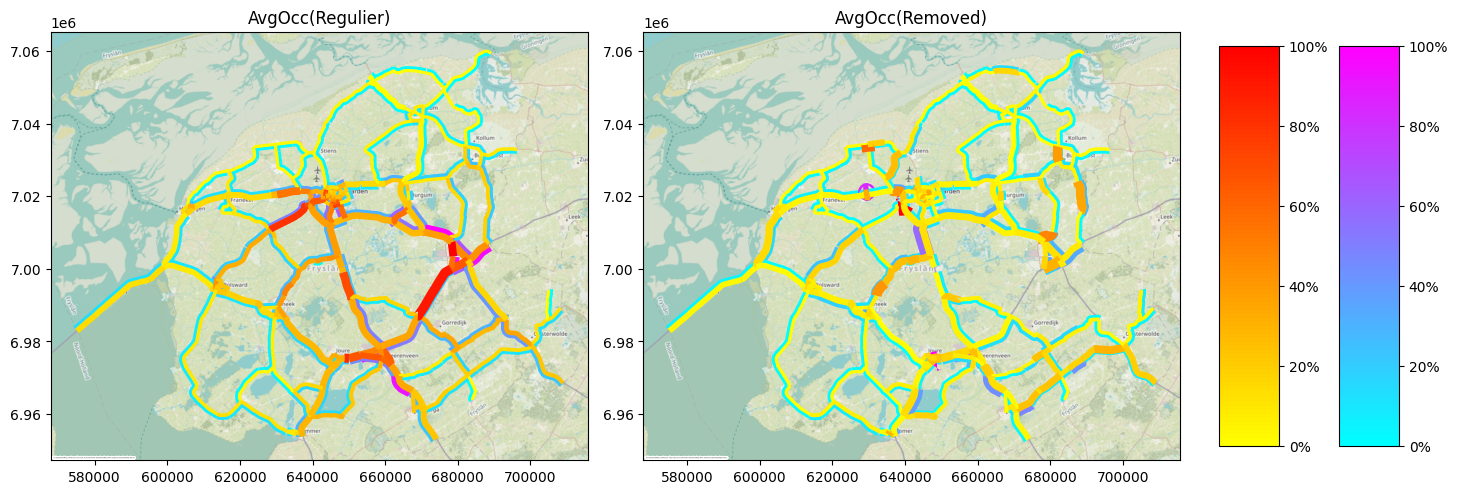

In [21]:
folders = [load_files('regular/', 6), load_files('removed/', 6, offset=0)]
labels = ['Regulier', 'Removed']
# lwk = load_files('', 1)

fig, (ax) = plt.subplots(1, len(folders), figsize=(12, 5))
# plt.figure(figsize=(8,8), dpi=200)
# ax = plt.subplot()

if len(folders) == 1:
    ax = [ax]

cmap = plt.cm.get_cmap('autumn_r', 100)
cmap2 = plt.cm.get_cmap('cool', 100)

cax = plt.axes([0.92 +0.1, 0.1, 0.05, 0.8])
cax2 = plt.axes([0.92+0.1 +0.1, 0.1, 0.05, 0.8])

# left_shift2 = lines_gpd.apply(lambda r: r.geometry.offset_curve(-400), axis=1)

def show_plot(ax, ldf, label):
    # offset line
    left_shift2 = ldf.copy()
    line_offset2 = 800
    def update_offset2(row):
        return row.geometry.offset_curve(-line_offset2)
    left_shift2['geometry'] = left_shift2.apply(update_offset2, axis=1)

    # configure coordinates of plane, comment out to ignore
    # ax.set_xlim(63e4, 69.5e4)
    # ax.set_ylim(6.945e6, 7.01e6)
    ax.set_title(f"AvgOcc({label})")

    left_shift2.plot(ax=ax, column=ldf[f"avgb"]/ldf["capacity"],
                    cmap='cool',
                    linewidth=0.7+ldf['nbanen']*1.5 + 2*ldf[f"avgb"]/ldf["capacity"],
                    zorder=1)
    ldf.plot(ax=ax, column=ldf[f"avgf"]/ldf["capacity"],
                    cmap='autumn_r',
                    linewidth=0.7+ldf['nbanen']*1.5 + 2*ldf[f"avgf"]/ldf["capacity"],
                    zorder=1)
    
    cx.add_basemap(ax, attribution_size=1)

    # ax.set_axis_off()

    
    bar_info = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
    bar_info._A = [] ### geen idee wat dit doet
    cbar = plt.colorbar(bar_info, cax=cax, ax=ax, ticks=[0, 20, 40, 60, 80, 100])
    cbar.ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    bar_info = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=0, vmax=100))
    bar_info._A = [] ### geen idee wat dit doet
    cbar = plt.colorbar(bar_info, cax=cax2, ax=ax)
    cbar.ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

    def calc_intensity(edge):
        row = ldf[(ldf['node_start'] == edge[0]) & (ldf['node_end'] == edge[1])]
        return (row['avgf']/row['capacity']).to_list()[0]

    if label == 'Leeuwarden simple':
        for e in [(174, 108), (175, 174), (6, 175)]:
            print(f'({label}, outer ring): {calc_intensity(e)*100:.0f}%')
    if label == 'Leeuwarden new':
        for e in [(703, 108), (174, 703), (175, 174), (175, 6)]:
            print(f'({label}, outer ring): {calc_intensity(e)*100:.0f}%')

for i in range(len(folders)):
    ldf = folders[i][0]
    for j in range(len(folders[i])):
        # take average across all minutes excl initialization
        ldf[f'avgf{j}'] = folders[i][j][[f'f{k}' for k in range(0, 450)]].mean(axis=1)
        ldf[f'avgb{j}'] = folders[i][j][[f'b{k}' for k in range(0, 450)]].mean(axis=1)
    
    ldf['avgf'] = ldf[[f'avgf{j}' for j in range(len(folders[i]))]].mean(axis=1)
    ldf['avgb'] = ldf[[f'avgb{j}' for j in range(len(folders[i]))]].mean(axis=1)
    
    label = labels[i]
    show_plot(ax[i], ldf, label)

fig.tight_layout()

C:\Users\Alexander\AppData\Local\Temp\ipykernel_8168\1194541689.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('autumn_r', 100)
C:\Users\Alexander\AppData\Local\Temp\ipykernel_8168\1194541689.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = plt.cm.get_cmap('cool', 100)
C:\Users\Alexander\AppData\Local\Temp\ipykernel_8168\1194541689.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
C:\Users\Alexander\AppData\Local\Temp\ipykernel_8168\1194541689.

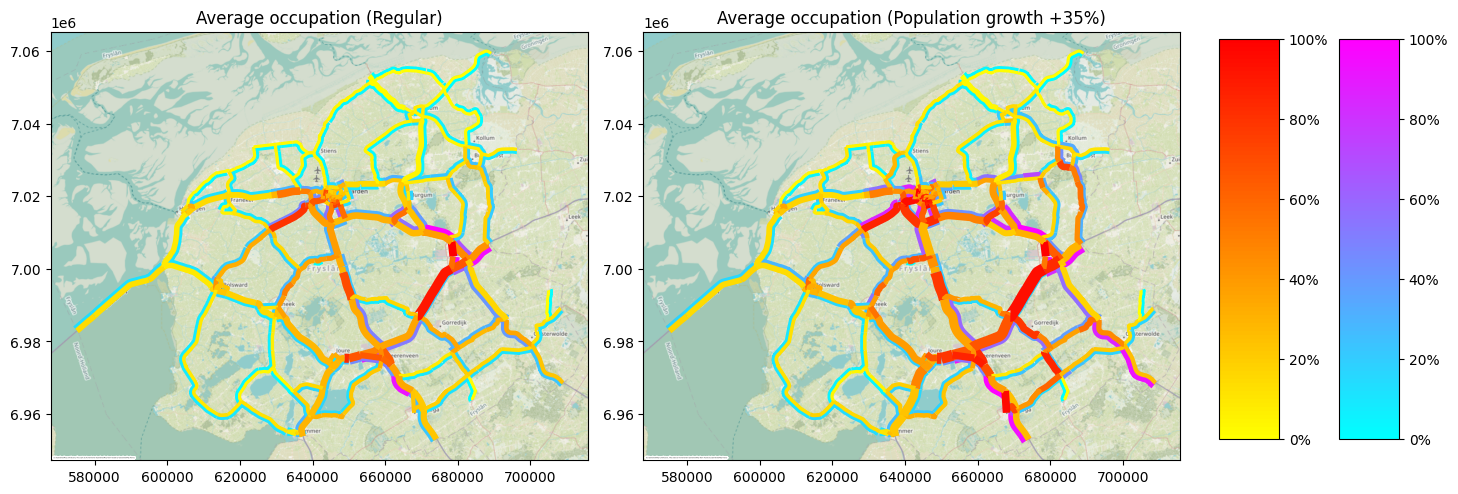

In [22]:
folders = [load_files('regular/', 6), load_files('popgrow/', 6, offset=0)]
labels = ['Regular', 'Population growth +35%']
# lwk = load_files('', 1)

fig, (ax) = plt.subplots(1, len(folders), figsize=(12, 5))
# plt.figure(figsize=(8,8), dpi=200)
# ax = plt.subplot()

if len(folders) == 1:
    ax = [ax]

cmap = plt.cm.get_cmap('autumn_r', 100)
cmap2 = plt.cm.get_cmap('cool', 100)

cax = plt.axes([0.92 +0.1, 0.1, 0.05, 0.8])
cax2 = plt.axes([0.92+0.1 +0.1, 0.1, 0.05, 0.8])

# left_shift2 = lines_gpd.apply(lambda r: r.geometry.offset_curve(-400), axis=1)

def show_plot(ax, ldf, label):
    # offset line
    left_shift2 = ldf.copy()
    line_offset2 = 800
    def update_offset2(row):
        return row.geometry.offset_curve(-line_offset2)
    left_shift2['geometry'] = left_shift2.apply(update_offset2, axis=1)

    # configure coordinates of plane, comment out to ignore
    # ax.set_xlim(63e4, 69.5e4)
    # ax.set_ylim(6.945e6, 7.01e6)
    ax.set_title(f"Average occupation ({label})")

    left_shift2.plot(ax=ax, column=ldf[f"avgb"]/ldf["capacity"],
                    cmap='cool',
                    linewidth=0.7+ldf['nbanen']*1.5 + 2*ldf[f"avgb"]/ldf["capacity"],
                    zorder=1)
    ldf.plot(ax=ax, column=ldf[f"avgf"]/ldf["capacity"],
                    cmap='autumn_r',
                    linewidth=0.7+ldf['nbanen']*1.5 + 2*ldf[f"avgf"]/ldf["capacity"],
                    zorder=1)
    
    cx.add_basemap(ax, attribution_size=1)

    # ax.set_axis_off()

    
    bar_info = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
    bar_info._A = [] ### geen idee wat dit doet
    cbar = plt.colorbar(bar_info, cax=cax, ax=ax, ticks=[0, 20, 40, 60, 80, 100])
    cbar.ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    bar_info = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=0, vmax=100))
    bar_info._A = [] ### geen idee wat dit doet
    cbar = plt.colorbar(bar_info, cax=cax2, ax=ax)
    cbar.ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

    def calc_intensity(edge):
        row = ldf[(ldf['node_start'] == edge[0]) & (ldf['node_end'] == edge[1])]
        return (row['avgf']/row['capacity']).to_list()[0]

    if label == 'Leeuwarden simple':
        for e in [(174, 108), (175, 174), (6, 175)]:
            print(f'({label}, outer ring): {calc_intensity(e)*100:.0f}%')
    if label == 'Leeuwarden new':
        for e in [(703, 108), (174, 703), (175, 174), (175, 6)]:
            print(f'({label}, outer ring): {calc_intensity(e)*100:.0f}%')

for i in range(len(folders)):
    ldf = folders[i][0]
    for j in range(len(folders[i])):
        # take average across all minutes excl initialization
        ldf[f'avgf{j}'] = folders[i][j][[f'f{k}' for k in range(0, 450)]].mean(axis=1)
        ldf[f'avgb{j}'] = folders[i][j][[f'b{k}' for k in range(0, 450)]].mean(axis=1)
    
    ldf['avgf'] = ldf[[f'avgf{j}' for j in range(len(folders[i]))]].mean(axis=1)
    ldf['avgb'] = ldf[[f'avgb{j}' for j in range(len(folders[i]))]].mean(axis=1)
    
    label = labels[i]
    show_plot(ax[i], ldf, label)

fig.tight_layout()

---

In [23]:
lines_gpd = pd.read_csv('./gendata/test1.csv')
lines_gpd[(lines_gpd['node_start'] == 189) & (lines_gpd['node_end'] == 168)]

FileNotFoundError: [Errno 2] No such file or directory: './gendata/test1.csv'

In [ ]:
lines_gpd = pd.read_csv('./gendata/traveltimes regular/test1.csv')
lines_gpd[(lines_gpd['node_start'] == 189) & (lines_gpd['node_end'] == 168)]

Unnamed: 0 wegnr       length  maxshd  node_start  node_end  nbanen  \
223         223   032  4698.275432     100         189       168       2   

       capacity                                           geometry     f0  \
223  156.464307  LINESTRING (650824.9015559059 6991563.05982829...  115.0   

     ...   b90   b91   b92   b93   b94   b95   b96   b97   b98   b99  
223  ...  56.0  60.0  64.0  70.0  73.0  65.0  64.0  58.0  61.0  52.0  

[1 rows x 209 columns]

<timed exec>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
<timed exec>:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


98, CPU times: total: 1.3 s
Wall time: 1.31 s


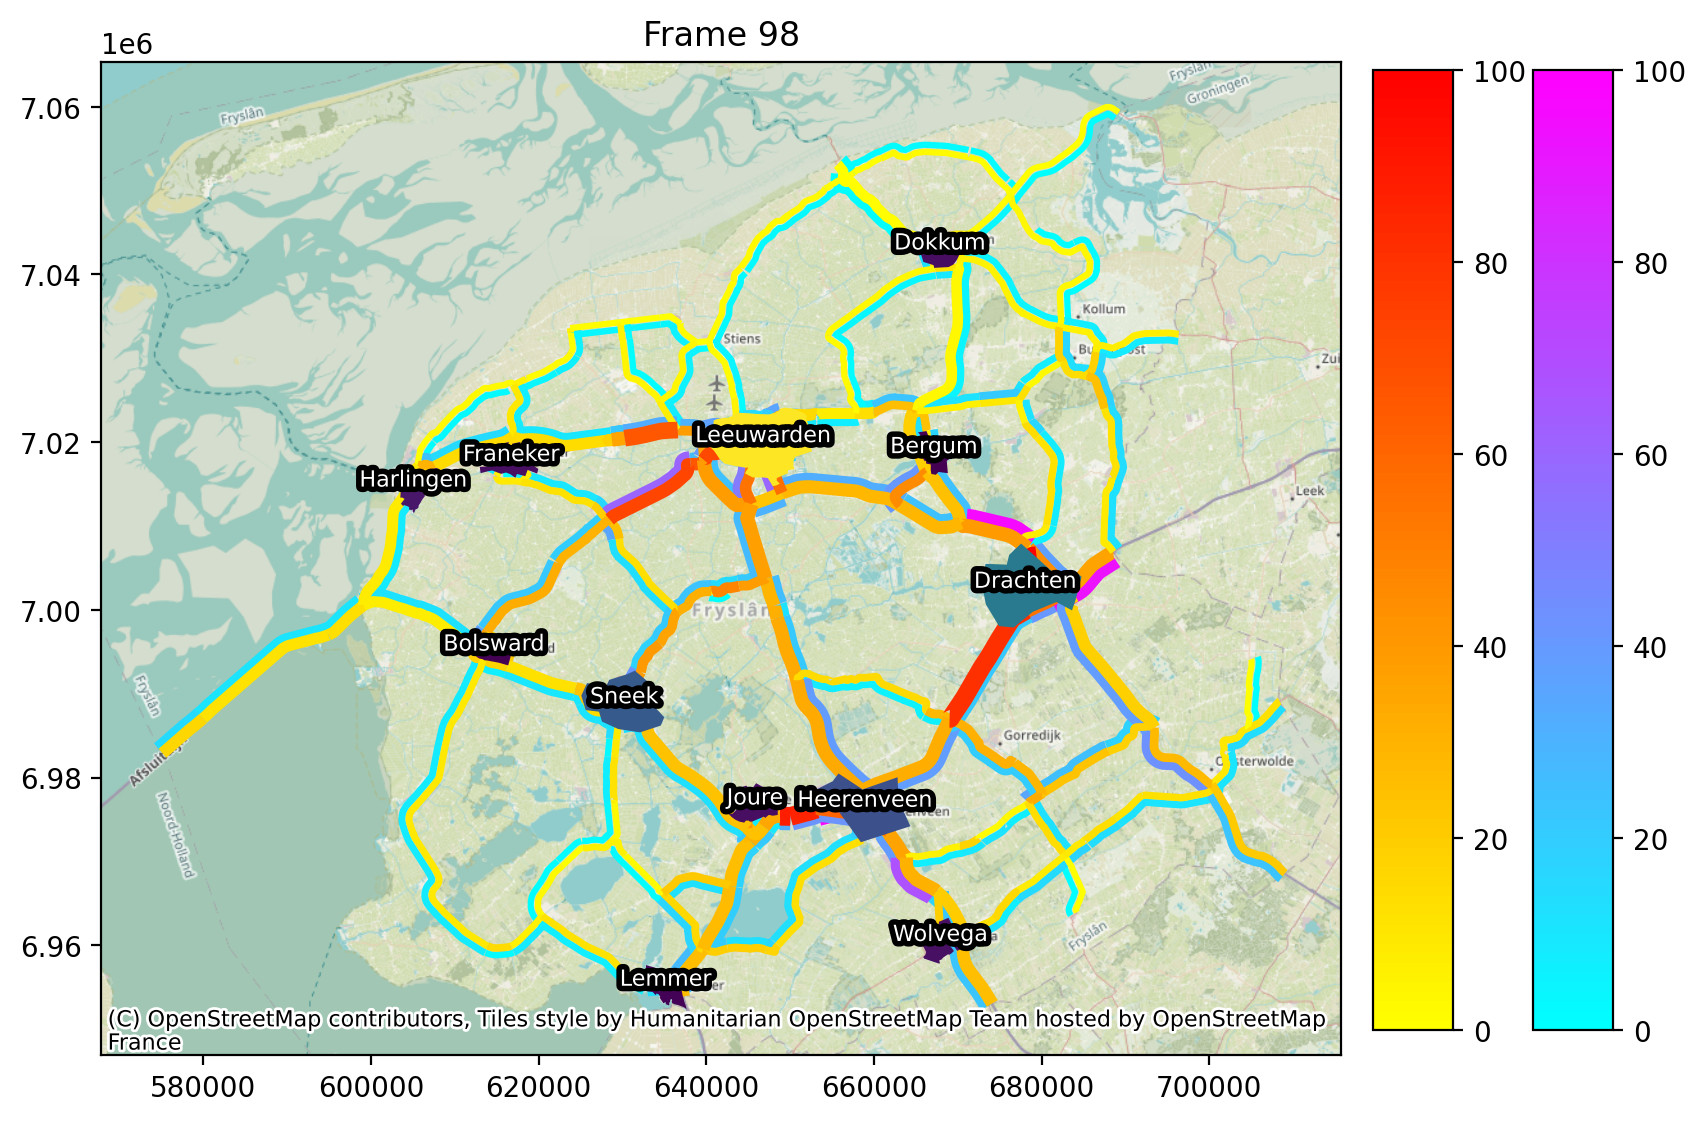

In [ ]:
%%time

lines_gpd = pd.read_csv('./gendata/test1.csv')

lines_gpd['geometry'] = lines_gpd['geometry'].apply(wkt.loads)
lines_gpd = gpd.GeoDataFrame(lines_gpd, crs='epsg:3857')

lines_gpd_copy = lines_gpd.copy()
lines_gpd = lines_gpd.explode()

line_offset = 850
line_offset2 = 150
left_shift = lines_gpd.copy()
left_shift2 = lines_gpd.copy()

# def is_rightsided(geom): # is northeast or southeast
#     dx = geom.coords[-1][0] - geom.coords[0][0]
#     return dx > 0

# left_shift['geometry'] = left_shift.geometry.apply(lambda k: k if is_rightsided(k) else k.reverse())
# manual_indices = [137, 103, 280, 164, 80, 123, 85, 86, 173, 175, 176]

def update_offset(row):
    # if row.name in manual_indices: # row.name is index
    #     return row.geometry.offset_curve(line_offset)
    return row.geometry.offset_curve(-line_offset)

def update_offset2(row):
    return row.geometry.offset_curve(-line_offset2)

left_shift['geometry'] = left_shift.apply(update_offset, axis=1)
left_shift2['geometry'] = left_shift2.apply(update_offset2, axis=1)
cities = gpd.read_file('./wegengraaf2/cities.shp').to_crs(epsg=3857)
# left_shift[left_shift['node_start'] == 142]

plt.figure(figsize=(8,8), dpi=200)
ax = plt.subplot()

cmap = plt.cm.get_cmap('autumn_r', 100)
cmap2 = plt.cm.get_cmap('cool', 100)

cax = plt.axes([0.92, 0.2, 0.05, 0.6])
cax2 = plt.axes([0.92+0.1, 0.2, 0.05, 0.6])

def update(i):
    ax.clear()
    ax.set_title(f"Frame {i}")

    left_shift.plot(ax=ax, column=lines_gpd[f"b{i}"]/lines_gpd["capacity"],
                    cmap='cool',
                    linewidth=0.7+lines_gpd['nbanen']*1.5 + 2*lines_gpd[f"b{i}"]/lines_gpd["capacity"],
                    zorder=1)
    lines_gpd.plot(ax=ax, column=lines_gpd[f"f{i}"]/lines_gpd["capacity"],
                    cmap='autumn_r',
                    linewidth=0.7+lines_gpd['nbanen']*1.5 + 2*lines_gpd[f"f{i}"]/lines_gpd["capacity"],
                    zorder=1)
    
    # nodes_gpd.plot(ax=ax, markersize=10, color='black', zorder=2)
    cities.plot(ax=ax, 
            column='population')
    cities.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], size=8, ha='center', color='white', path_effects=[pe.withStroke(linewidth=4, foreground="black")]), axis=1)
        
    cx.add_basemap(ax)

    
    bar_info = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
    bar_info._A = [] ### geen idee wat dit doet
    cbar = plt.colorbar(bar_info, cax=cax, ax=ax)
    bar_info = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=0, vmax=100))
    bar_info._A = [] ### geen idee wat dit doet
    cbar = plt.colorbar(bar_info, cax=cax2, ax=ax)

    # plt.tight_layout()
    # plt.savefig('./img2/%02d.png' % i, dpi=200, bbox_inches='tight')
    print('%02d' % i, end=', ')

for k in range(98, 99): # minutes_sim
    update(k)
